In [1]:
!pip install timm
!pip install lightning
!pip install astropy
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('/content/')

from dataloader_fits import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_path = '/content/drive/MyDrive/Dataset/aia_synoptic_copy_1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [2]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [3]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [4]:
dataset = SunImageDataset(csv_file="/content/dataset_full_2024_with_cr_4days.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size-24]
k_fold_2_indices = indices[fold_size+24:(2*fold_size)-24]
k_fold_3_indices = indices[(2*fold_size)+24:(3*fold_size)-24]
k_fold_4_indices = indices[(3*fold_size)+24:(4*fold_size)-24]
k_fold_5_indices = indices[(4*fold_size)+24:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list
kp_dates = pd.read_csv("/content/matched_kp_dates_full_2024_with_cr_4days.csv")
kp_dates_list = kp_dates["date"].tolist()

1869
1845
1845
1845
1872


In [5]:
# Get active indices
dataset_csv_file = pd.read_csv("/content/dataset_full_2024_with_cr_4days.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)

active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))

for dataloader in active_dataloaders:
    print(len(dataloader))

417
601
592
296
737


In [6]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()

        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)

        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )


        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size*2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()

        )

    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """

        batch_size = images.shape[0]

        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)

        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)

        image_features = image_features[:, -1, :]
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

In [7]:
torch.cuda.empty_cache()

In [8]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1

    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):

    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss

def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1





In [9]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, worker_init_fn=lambda _: np.random.seed(42))
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()

              # Forward pass with autograd
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              # print("Label: ", labels)
              outputs = model(images).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')




INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  2.0539231011349752


Validation Progress: Epoch: 1:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.5078957009674652


Training Progress: Epoch: 2:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  1.5430323154910055


Validation Progress: Epoch: 2:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.874392888684605


Training Progress: Epoch: 3:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  1.181119300193212


Validation Progress: Epoch: 3:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.4259597724979138


Training Progress: Epoch: 4:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.8501282910094732


Validation Progress: Epoch: 4:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.6604124029370568


Training Progress: Epoch: 5:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.6625767145279


Validation Progress: Epoch: 5:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.6139482855505465


Training Progress: Epoch: 6:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.5376110922089935


Validation Progress: Epoch: 6:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.6914612506789612


Training Progress: Epoch: 7:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.43989924821545756


Validation Progress: Epoch: 7:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.6792935241180023


Training Progress: Epoch: 8:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.37066454940630816


Validation Progress: Epoch: 8:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.7555635837637633


Training Progress: Epoch: 9:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.3291473663658128


Validation Progress: Epoch: 9:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.0486447797611325


Training Progress: Epoch: 10:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.28311600549890004


Validation Progress: Epoch: 10:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.902725491679789


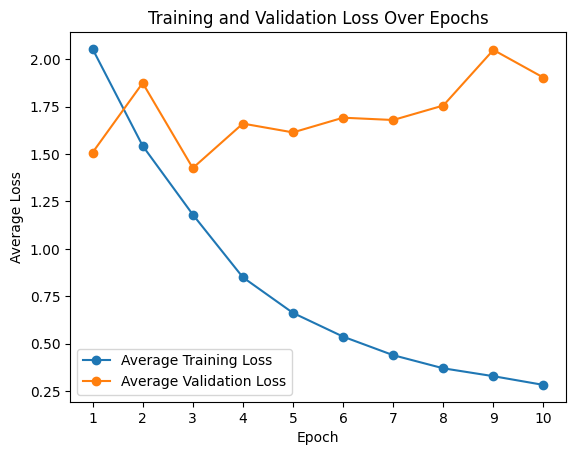

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/935 [00:00<?, ?it/s]

Average test loss: 1.9027
RMSE: 1.3794
MSE: 1.9032
MAE: 1.1107
R²: -0.2200
R: 0.2564
True Skill Score: 0.0873
Accuracy: 0.6811
Precision: 0.3242
Recall: 0.3957
F1 Score: 0.3564


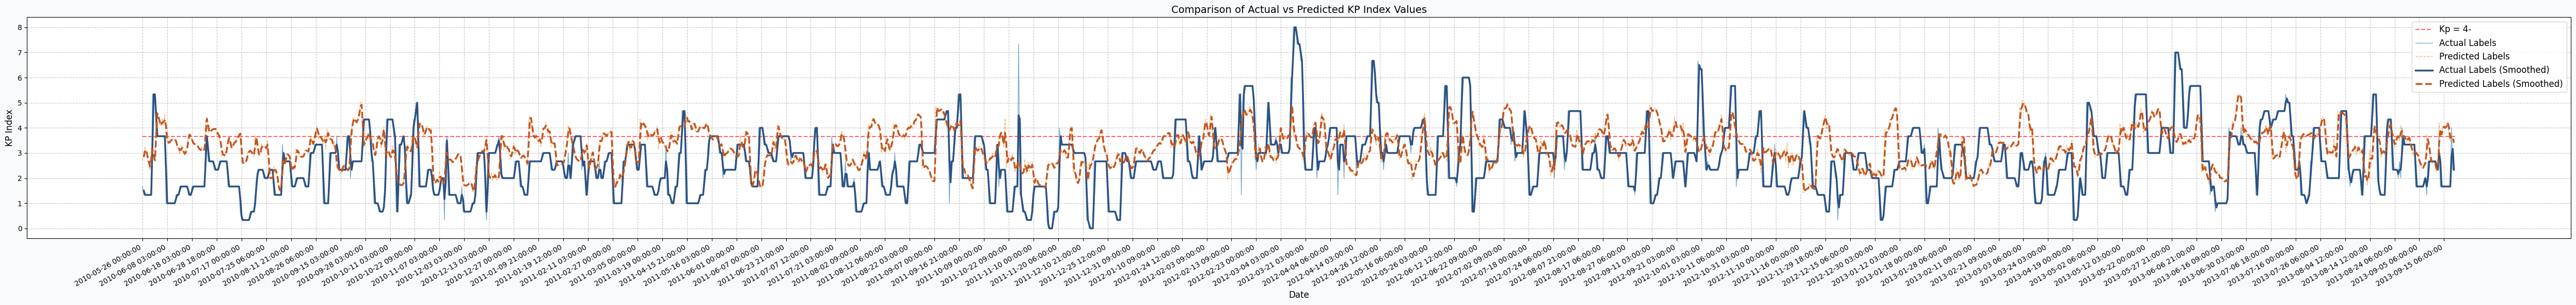

[np.float32(2.703125), np.float32(2.96875), np.float32(3.234375), np.float32(3.0), np.float32(2.734375), np.float32(2.59375), np.float32(2.328125), np.float32(3.1875), np.float32(3.109375), np.float32(2.75), np.float32(2.671875), np.float32(4.6875), np.float32(4.46875), np.float32(4.375), np.float32(4.09375), np.float32(4.09375), np.float32(4.34375), np.float32(4.125), np.float32(4.53125), np.float32(3.609375), np.float32(3.46875), np.float32(3.359375), np.float32(3.484375), np.float32(3.5), np.float32(3.5625), np.float32(3.546875), np.float32(3.546875), np.float32(3.421875), np.float32(3.1875), np.float32(3.265625), np.float32(2.953125), np.float32(3.296875), np.float32(3.125), np.float32(3.03125), np.float32(2.90625), np.float32(3.125), np.float32(3.203125), np.float32(3.734375), np.float32(3.734375), np.float32(3.59375), np.float32(3.46875), np.float32(3.34375), np.float32(3.359375), np.float32(3.34375), np.float32(3.296875), np.float32(3.1875), np.float32(3.125), np.float32(3.10937

Testing Progress:   0%|          | 0/209 [00:00<?, ?it/s]

Average test loss: 2.0242
RMSE: 1.4228
MSE: 2.0290
MAE: 1.1194
R²: -1.5186
R: 0.2319


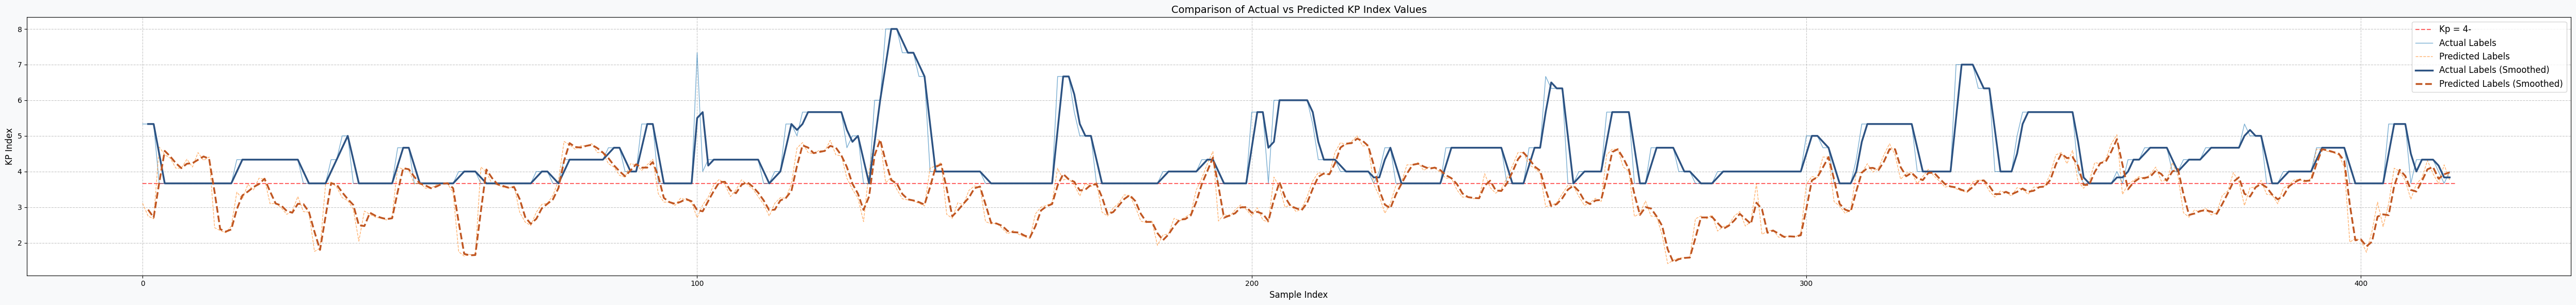

[np.float32(3.109375), np.float32(2.75), np.float32(2.671875), np.float32(4.6875), np.float32(4.46875), np.float32(4.375), np.float32(4.09375), np.float32(4.09375), np.float32(4.34375), np.float32(4.125), np.float32(4.53125), np.float32(4.3125), np.float32(4.40625), np.float32(2.421875), np.float32(2.34375), np.float32(2.28125), np.float32(2.46875), np.float32(3.421875), np.float32(3.234375), np.float32(3.640625), np.float32(3.484375), np.float32(3.8125), np.float32(3.78125), np.float32(3.09375), np.float32(3.109375), np.float32(2.984375), np.float32(2.796875), np.float32(2.890625), np.float32(3.296875), np.float32(2.875), np.float32(2.859375), np.float32(1.7578125), np.float32(1.84375), np.float32(3.640625), np.float32(3.703125), np.float32(3.5625), np.float32(3.265625), np.float32(3.1875), np.float32(2.9375), np.float32(2.046875), np.float32(2.890625), np.float32(2.796875), np.float32(2.71875), np.float32(2.6875), np.float32(2.640625), np.float32(2.734375), np.float32(4.125), np.floa

Training Progress: Epoch: 1:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.9340394206494016


Validation Progress: Epoch: 1:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.798962429814839


Training Progress: Epoch: 2:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.4101646904734242


Validation Progress: Epoch: 2:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.1030946269486797


Training Progress: Epoch: 3:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.0608267584080588


Validation Progress: Epoch: 3:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.8636344072076882


Training Progress: Epoch: 4:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.804809851040335


Validation Progress: Epoch: 4:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.137709354224832


Training Progress: Epoch: 5:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.6293105340342983


Validation Progress: Epoch: 5:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.1792842676044164


Training Progress: Epoch: 6:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.48562190815341827


Validation Progress: Epoch: 6:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.0761371473304373


Training Progress: Epoch: 7:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.4104587064397418


Validation Progress: Epoch: 7:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.404188935370409


Training Progress: Epoch: 8:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.4460468834152549


Validation Progress: Epoch: 8:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.2380916567242837


Training Progress: Epoch: 9:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.31942083827432055


Validation Progress: Epoch: 9:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.0970840610519357


Training Progress: Epoch: 10:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.2685994880659086


Validation Progress: Epoch: 10:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.128477823869782


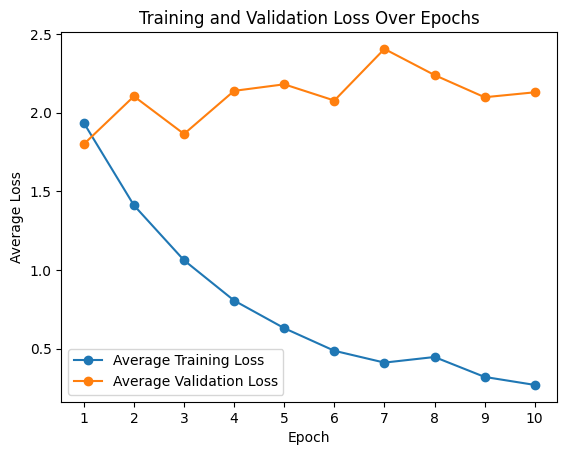

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/923 [00:00<?, ?it/s]

Average test loss: 2.1285
RMSE: 1.4589
MSE: 2.1277
MAE: 1.1672
R²: -0.1661
R: 0.1617
True Skill Score: 0.2368
Accuracy: 0.6390
Precision: 0.4129
Recall: 0.2562
F1 Score: 0.3162


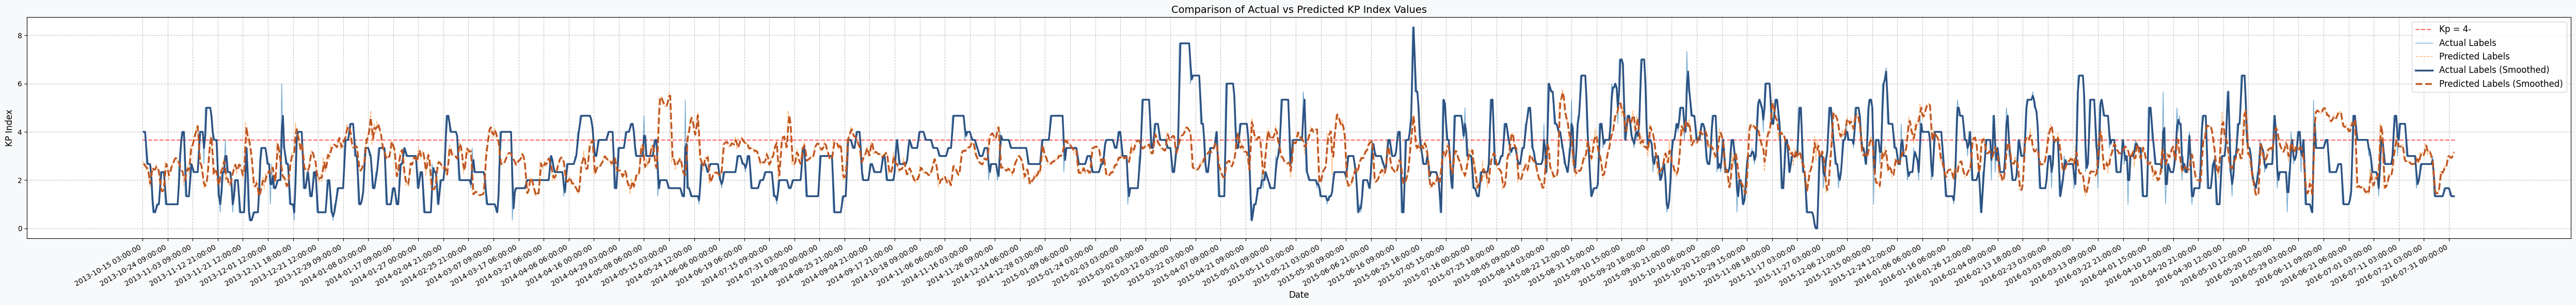

[np.float32(2.796875), np.float32(2.578125), np.float32(2.640625), np.float32(2.421875), np.float32(2.53125), np.float32(1.9765625), np.float32(1.734375), np.float32(2.5625), np.float32(2.46875), np.float32(2.40625), np.float32(2.46875), np.float32(2.640625), np.float32(2.4375), np.float32(2.28125), np.float32(1.6484375), np.float32(1.515625), np.float32(1.5546875), np.float32(1.71875), np.float32(2.765625), np.float32(2.578125), np.float32(2.40625), np.float32(2.0), np.float32(2.515625), np.float32(2.546875), np.float32(2.703125), np.float32(2.84375), np.float32(2.953125), np.float32(2.859375), np.float32(2.75), np.float32(2.71875), np.float32(2.421875), np.float32(2.390625), np.float32(2.3125), np.float32(1.78125), np.float32(2.265625), np.float32(2.34375), np.float32(2.59375), np.float32(2.265625), np.float32(3.40625), np.float32(3.375), np.float32(3.53125), np.float32(3.828125), np.float32(3.9375), np.float32(4.1875), np.float32(4.28125), np.float32(2.65625), np.float32(2.796875), 

Testing Progress:   0%|          | 0/301 [00:00<?, ?it/s]

Average test loss: 3.0589
RMSE: 1.7490
MSE: 3.0639
MAE: 1.4594
R²: -2.5527
R: 0.1613


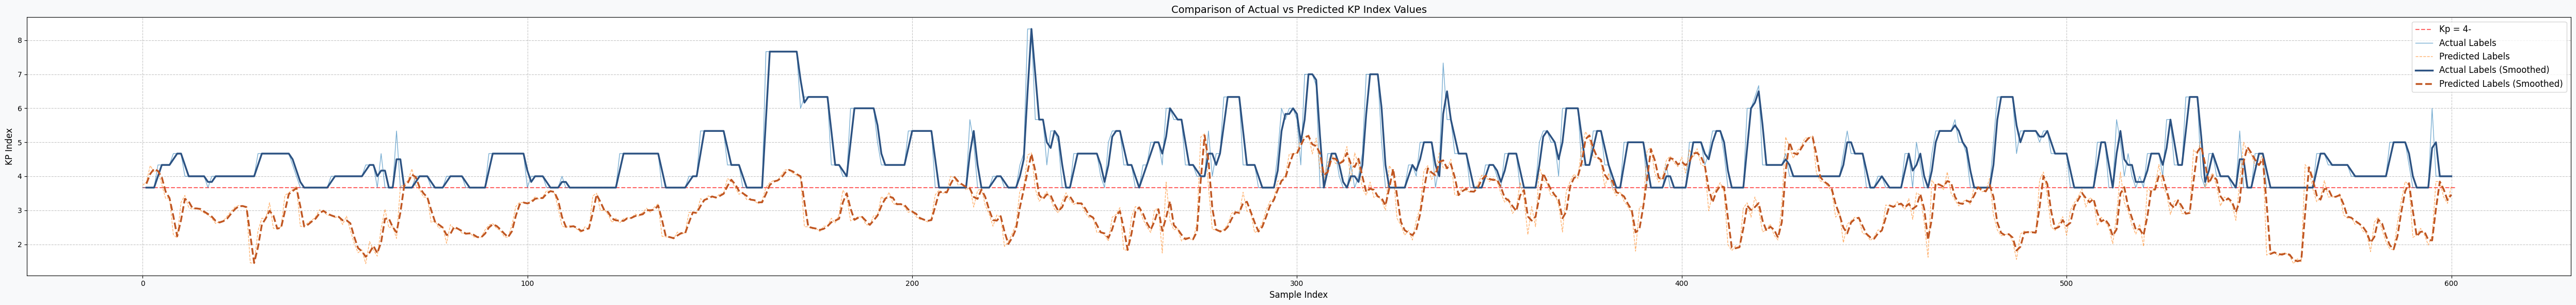

[np.float32(3.734375), np.float32(3.828125), np.float32(4.3125), np.float32(4.125), np.float32(4.1875), np.float32(3.75), np.float32(3.34375), np.float32(3.375), np.float32(2.28125), np.float32(2.1875), np.float32(3.234375), np.float32(3.4375), np.float32(3.078125), np.float32(3.03125), np.float32(3.078125), np.float32(3.0), np.float32(2.921875), np.float32(2.859375), np.float32(2.765625), np.float32(2.609375), np.float32(2.671875), np.float32(2.6875), np.float32(2.828125), np.float32(2.96875), np.float32(3.09375), np.float32(3.140625), np.float32(3.109375), np.float32(3.078125), np.float32(1.453125), np.float32(1.4453125), np.float32(2.390625), np.float32(2.765625), np.float32(2.75), np.float32(3.21875), np.float32(2.46875), np.float32(2.453125), np.float32(2.515625), np.float32(3.4375), np.float32(3.515625), np.float32(3.609375), np.float32(3.703125), np.float32(2.53125), np.float32(2.515625), np.float32(2.640625), np.float32(2.703125), np.float32(2.8125), np.float32(3.015625), np.fl

Training Progress: Epoch: 1:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.915509537151062


Validation Progress: Epoch: 1:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.592075237212824


Training Progress: Epoch: 2:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.427008800775639


Validation Progress: Epoch: 2:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.6947298848963515


Training Progress: Epoch: 3:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.0275521735051227


Validation Progress: Epoch: 3:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.8065949914488086


Training Progress: Epoch: 4:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.7695762695823205


Validation Progress: Epoch: 4:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.8242441548451651


Training Progress: Epoch: 5:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.5952935733405056


Validation Progress: Epoch: 5:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.6147181599839646


Training Progress: Epoch: 6:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.47769001981469905


Validation Progress: Epoch: 6:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.011846458416424


Training Progress: Epoch: 7:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.4043740353251825


Validation Progress: Epoch: 7:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.5891859949641343


Training Progress: Epoch: 8:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.3483696956827467


Validation Progress: Epoch: 8:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.4697685165271235


Training Progress: Epoch: 9:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.302403512047006


Validation Progress: Epoch: 9:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.6024356830779631


Training Progress: Epoch: 10:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.2563589101712


Validation Progress: Epoch: 10:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.6783219494019788


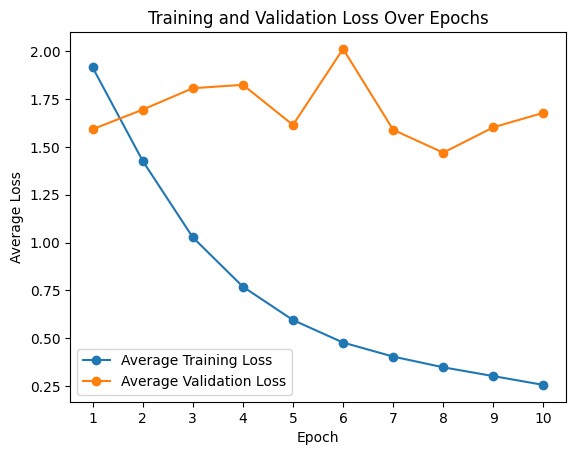

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/923 [00:00<?, ?it/s]

Average test loss: 1.6783
RMSE: 1.2955
MSE: 1.6786
MAE: 1.0246
R²: 0.0699
R: 0.4065
True Skill Score: 0.5445
Accuracy: 0.6986
Precision: 0.6011
Recall: 0.1807
F1 Score: 0.2779


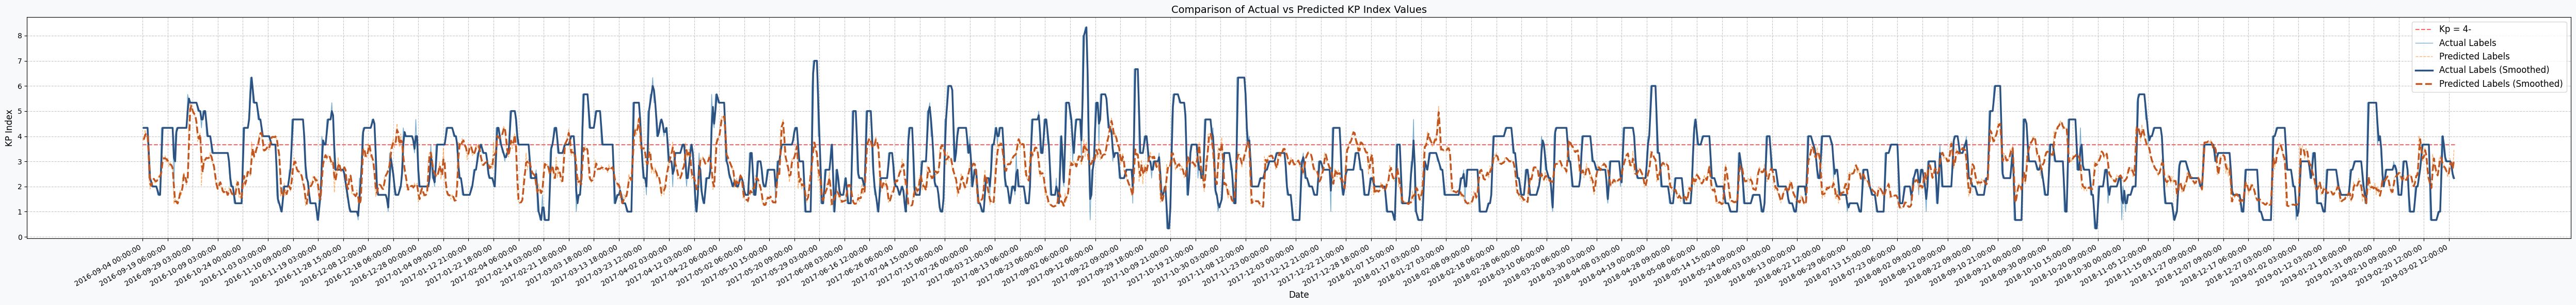

[np.float32(3.921875), np.float32(3.8125), np.float32(4.25), np.float32(3.984375), np.float32(4.0625), np.float32(2.359375), np.float32(1.8984375), np.float32(2.15625), np.float32(2.28125), np.float32(2.328125), np.float32(2.125), np.float32(2.28125), np.float32(2.25), np.float32(2.4375), np.float32(2.390625), np.float32(2.734375), np.float32(3.21875), np.float32(3.03125), np.float32(3.21875), np.float32(2.953125), np.float32(3.125), np.float32(2.796875), np.float32(2.96875), np.float32(2.734375), np.float32(2.75), np.float32(1.3046875), np.float32(1.5078125), np.float32(1.3125), np.float32(1.3359375), np.float32(1.640625), np.float32(1.8359375), np.float32(1.640625), np.float32(2.375), np.float32(2.5625), np.float32(2.265625), np.float32(2.0625), np.float32(2.453125), np.float32(4.8125), np.float32(5.3125), np.float32(5.125), np.float32(4.90625), np.float32(4.90625), np.float32(4.78125), np.float32(4.34375), np.float32(3.796875), np.float32(4.0), np.float32(4.125), np.float32(2.046875

Testing Progress:   0%|          | 0/296 [00:00<?, ?it/s]

Average test loss: 3.3330
RMSE: 1.8256
MSE: 3.3330
MAE: 1.5829
R²: -4.2944
R: 0.2713


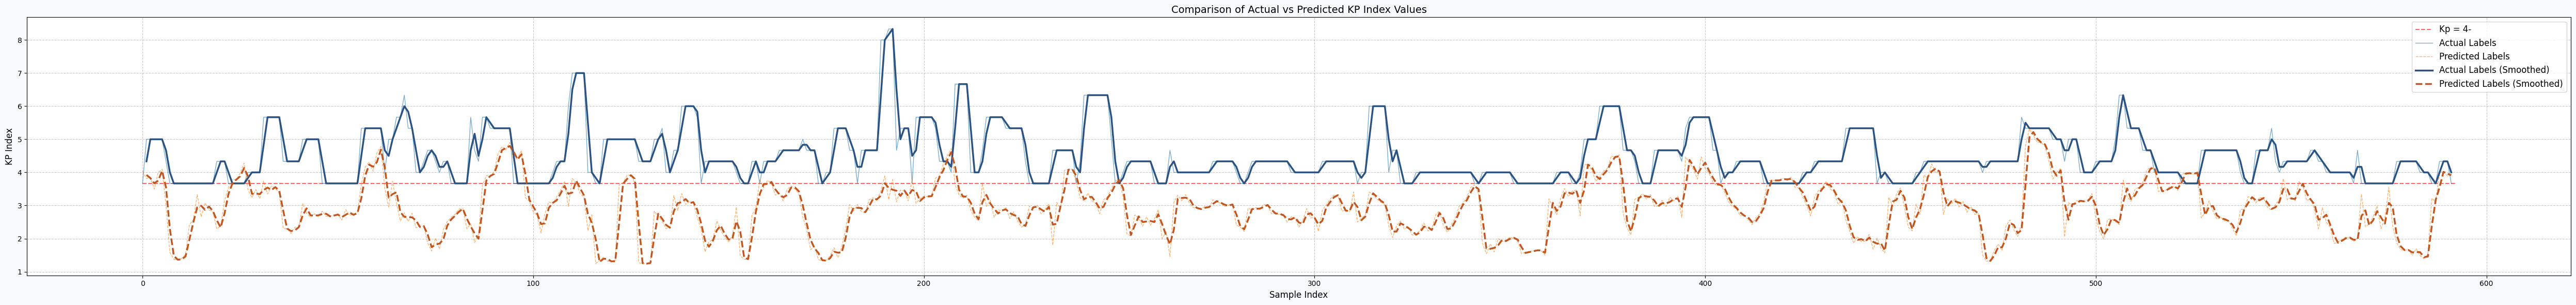

[np.float32(4.03125), np.float32(3.8125), np.float32(3.84375), np.float32(3.5), np.float32(4.0), np.float32(4.09375), np.float32(3.0), np.float32(1.578125), np.float32(1.3828125), np.float32(1.34375), np.float32(1.3984375), np.float32(1.5234375), np.float32(2.421875), np.float32(2.5625), np.float32(3.328125), np.float32(2.65625), np.float32(3.078125), np.float32(2.859375), np.float32(2.8125), np.float32(2.296875), np.float32(2.375), np.float32(3.15625), np.float32(3.546875), np.float32(3.78125), np.float32(3.78125), np.float32(3.984375), np.float32(4.28125), np.float32(3.46875), np.float32(3.234375), np.float32(3.484375), np.float32(3.203125), np.float32(3.734375), np.float32(3.34375), np.float32(3.59375), np.float32(3.515625), np.float32(3.375), np.float32(2.3125), np.float32(2.296875), np.float32(2.15625), np.float32(2.34375), np.float32(2.34375), np.float32(3.0625), np.float32(2.765625), np.float32(2.640625), np.float32(2.75), np.float32(2.65625), np.float32(2.828125), np.float32(2.

Training Progress: Epoch: 1:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  2.1669121278682097


Validation Progress: Epoch: 1:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.1467571173384292


Training Progress: Epoch: 2:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.5873407826429224


Validation Progress: Epoch: 2:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.2466770793272954


Training Progress: Epoch: 3:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.1747666392662943


Validation Progress: Epoch: 3:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.18876794450094


Training Progress: Epoch: 4:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.8395097617379524


Validation Progress: Epoch: 4:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.2507816336717041


Training Progress: Epoch: 5:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.6388794798479875


Validation Progress: Epoch: 5:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.4108971528713932


Training Progress: Epoch: 6:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.5164614106687994


Validation Progress: Epoch: 6:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.4237166239305217


Training Progress: Epoch: 7:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.43378536904134724


Validation Progress: Epoch: 7:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.2467985022803623


Training Progress: Epoch: 8:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.35953740312673765


Validation Progress: Epoch: 8:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.3927434980275866


Training Progress: Epoch: 9:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.31176026835864334


Validation Progress: Epoch: 9:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.3551692815645495


Training Progress: Epoch: 10:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.2709444084247635


Validation Progress: Epoch: 10:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.265844213376026


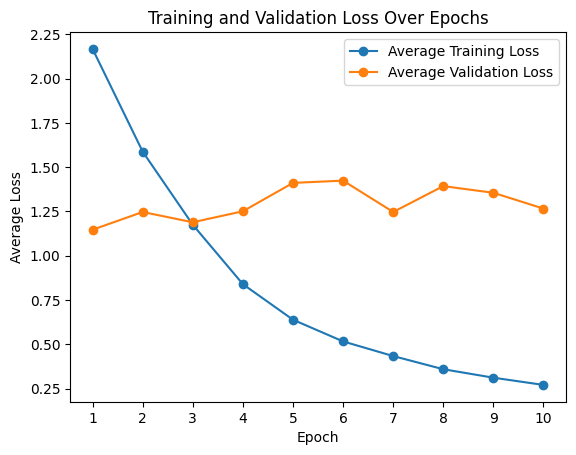

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/923 [00:00<?, ?it/s]

Average test loss: 1.2658
RMSE: 1.1251
MSE: 1.2662
MAE: 0.8683
R²: -0.0353
R: 0.2760
True Skill Score: 0.4926
Accuracy: 0.8401
Precision: 0.5094
Recall: 0.0912
F1 Score: 0.1547


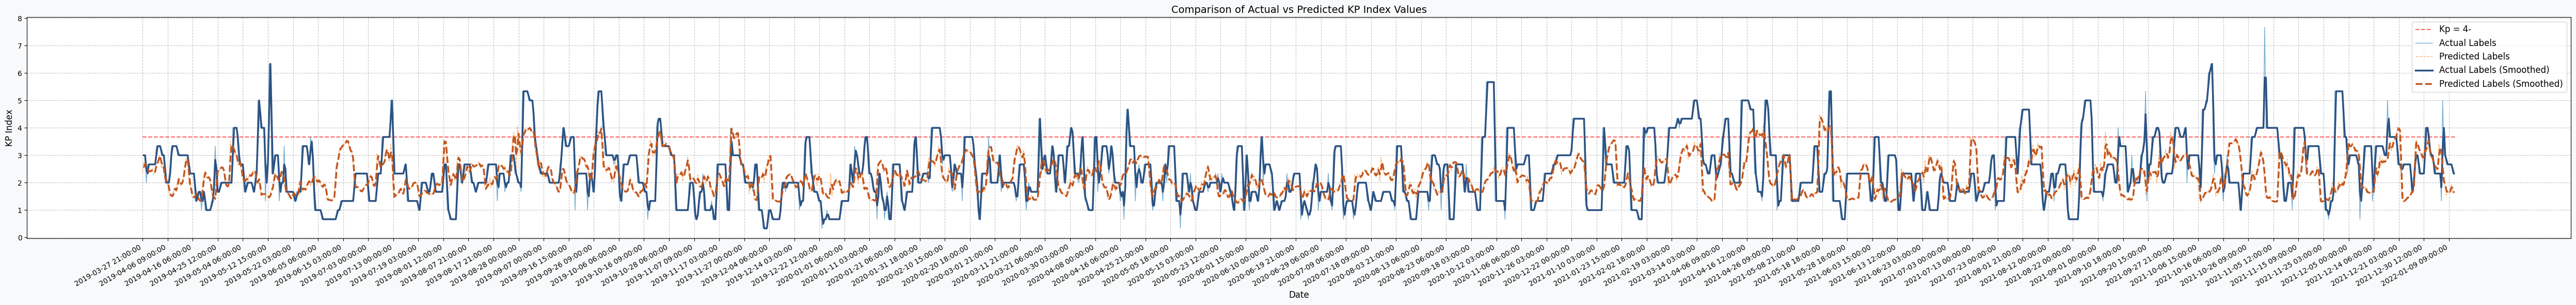

[np.float32(2.375), np.float32(2.734375), np.float32(2.640625), np.float32(2.578125), np.float32(2.484375), np.float32(2.34375), np.float32(2.484375), np.float32(2.390625), np.float32(2.53125), np.float32(2.296875), np.float32(2.484375), np.float32(2.75), np.float32(2.703125), np.float32(2.984375), np.float32(2.96875), np.float32(2.546875), np.float32(2.734375), np.float32(2.3125), np.float32(2.09375), np.float32(2.046875), np.float32(1.9921875), np.float32(1.6875), np.float32(1.5078125), np.float32(1.5390625), np.float32(1.484375), np.float32(1.7734375), np.float32(1.796875), np.float32(1.6640625), np.float32(2.15625), np.float32(2.109375), np.float32(1.8984375), np.float32(2.0), np.float32(2.0625), np.float32(2.4375), np.float32(2.734375), np.float32(2.921875), np.float32(2.8125), np.float32(1.9375), np.float32(1.90625), np.float32(1.53125), np.float32(1.4609375), np.float32(1.4765625), np.float32(1.53125), np.float32(1.6640625), np.float32(1.4140625), np.float32(1.359375), np.float3

Testing Progress:   0%|          | 0/148 [00:00<?, ?it/s]

Average test loss: 3.8639
RMSE: 1.9657
MSE: 3.8639
MAE: 1.7203
R²: -7.9729
R: 0.0507


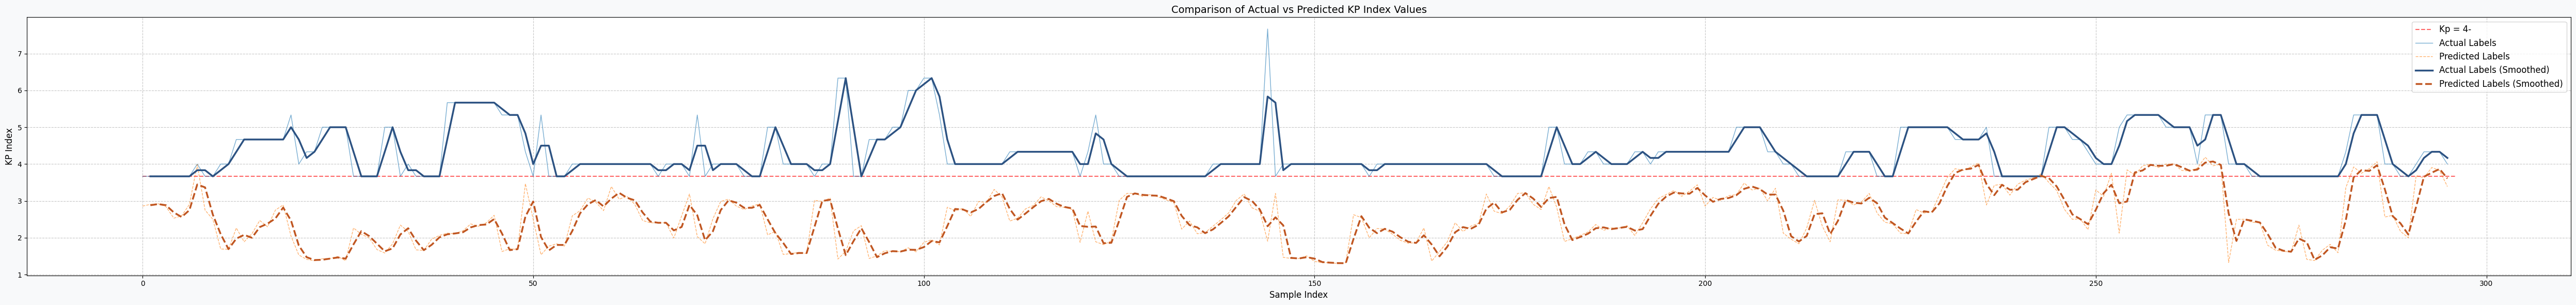

[np.float32(2.859375), np.float32(2.90625), np.float32(2.921875), np.float32(2.84375), np.float32(2.53125), np.float32(2.59375), np.float32(2.90625), np.float32(3.984375), np.float32(2.75), np.float32(2.5), np.float32(1.6953125), np.float32(1.6875), np.float32(2.265625), np.float32(1.890625), np.float32(2.109375), np.float32(2.46875), np.float32(2.296875), np.float32(2.75), np.float32(2.890625), np.float32(2.046875), np.float32(1.53125), np.float32(1.4140625), np.float32(1.375), np.float32(1.4296875), np.float32(1.4375), np.float32(1.4921875), np.float32(1.375), np.float32(2.265625), np.float32(2.09375), np.float32(2.0), np.float32(1.6796875), np.float32(1.5859375), np.float32(1.8359375), np.float32(2.34375), np.float32(2.171875), np.float32(1.671875), np.float32(1.65625), np.float32(1.9609375), np.float32(2.0625), np.float32(2.125), np.float32(2.109375), np.float32(2.1875), np.float32(2.375), np.float32(2.3125), np.float32(2.40625), np.float32(2.609375), np.float32(1.625), np.float32(

Training Progress: Epoch: 1:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  1.8436324670388369


Validation Progress: Epoch: 1:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.4625959101285844


Training Progress: Epoch: 2:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  1.3280005644239472


Validation Progress: Epoch: 2:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.2341814831363362


Training Progress: Epoch: 3:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  1.0044696663213106


Validation Progress: Epoch: 3:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.409718481158903


Training Progress: Epoch: 4:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.7520703317440182


Validation Progress: Epoch: 4:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.176517802201317


Training Progress: Epoch: 5:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.5707539879253692


Validation Progress: Epoch: 5:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.455813301020475


Training Progress: Epoch: 6:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.4609154690752689


Validation Progress: Epoch: 6:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.2760729605254157


Training Progress: Epoch: 7:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.382944938844475


Validation Progress: Epoch: 7:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.500588861887361


Training Progress: Epoch: 8:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.32893621072595824


Validation Progress: Epoch: 8:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.429878271725397


Training Progress: Epoch: 9:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.27627444692929637


Validation Progress: Epoch: 9:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.3054274591442168


Training Progress: Epoch: 10:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.25625051093938306


Validation Progress: Epoch: 10:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.738773078557409


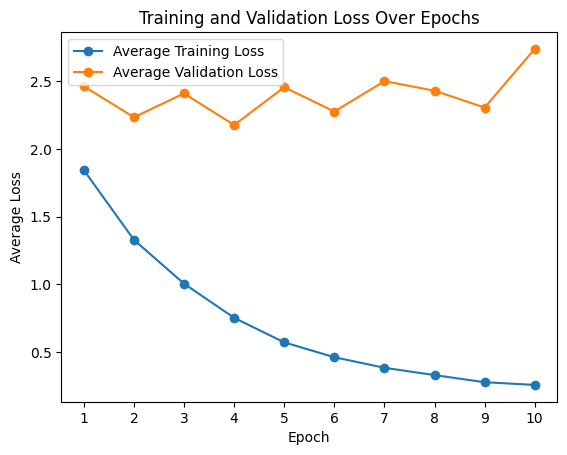

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/936 [00:00<?, ?it/s]

Average test loss: 2.7388
RMSE: 1.6549
MSE: 2.7388
MAE: 1.2276
R²: -0.4279
R: 0.1314
True Skill Score: 0.5210
Accuracy: 0.6207
Precision: 0.5818
Recall: 0.1303
F1 Score: 0.2129


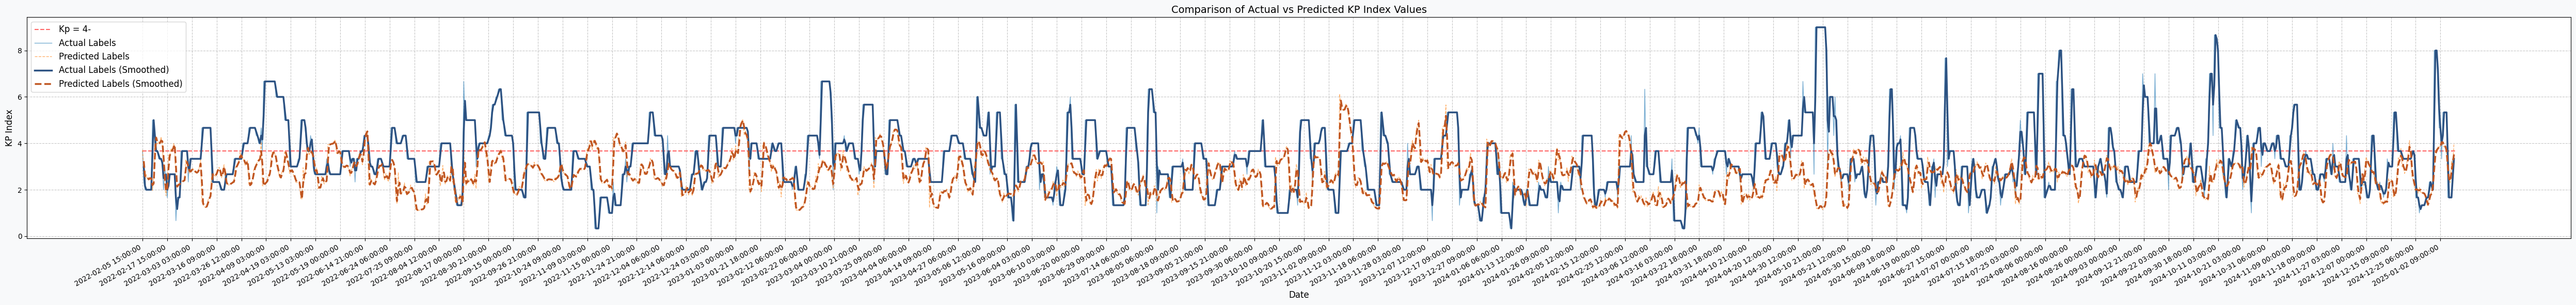

[np.float32(3.71875), np.float32(2.75), np.float32(2.421875), np.float32(2.65625), np.float32(2.453125), np.float32(2.4375), np.float32(2.5625), np.float32(2.421875), np.float32(1.96875), np.float32(2.5625), np.float32(4.34375), np.float32(4.15625), np.float32(3.96875), np.float32(4.0625), np.float32(3.953125), np.float32(4.28125), np.float32(3.90625), np.float32(2.953125), np.float32(2.15625), np.float32(1.7421875), np.float32(2.3125), np.float32(3.5), np.float32(3.421875), np.float32(3.78125), np.float32(3.625), np.float32(3.984375), np.float32(3.890625), np.float32(2.140625), np.float32(2.125), np.float32(2.28125), np.float32(2.203125), np.float32(2.328125), np.float32(2.375), np.float32(2.375), np.float32(2.4375), np.float32(3.3125), np.float32(3.09375), np.float32(2.90625), np.float32(2.71875), np.float32(2.84375), np.float32(2.875), np.float32(2.90625), np.float32(2.78125), np.float32(2.75), np.float32(2.71875), np.float32(2.84375), np.float32(2.953125), np.float32(3.296875), np.

Testing Progress:   0%|          | 0/369 [00:00<?, ?it/s]

Average test loss: 5.5924
RMSE: 2.3648
MSE: 5.5996
MAE: 1.9726
R²: -4.1509
R: -0.1330


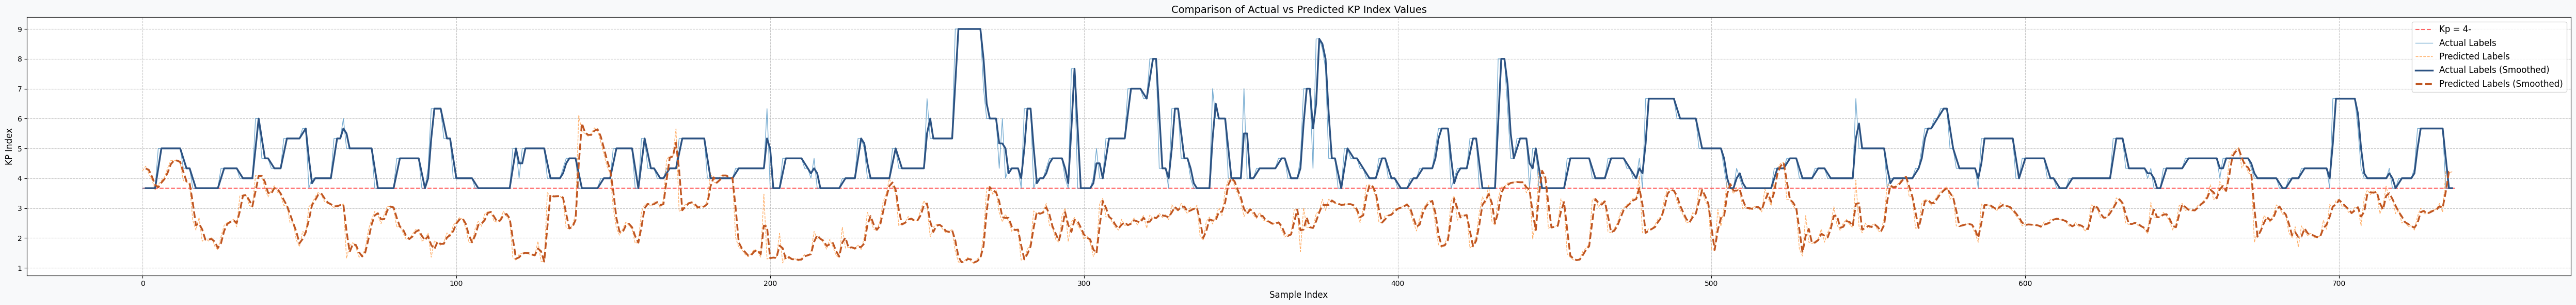

[np.float32(4.25), np.float32(4.40625), np.float32(4.15625), np.float32(3.953125), np.float32(3.609375), np.float32(3.78125), np.float32(3.921875), np.float32(4.03125), np.float32(4.34375), np.float32(4.59375), np.float32(4.59375), np.float32(4.59375), np.float32(4.5), np.float32(3.921875), np.float32(3.875), np.float32(3.78125), np.float32(2.59375), np.float32(2.265625), np.float32(2.6875), np.float32(1.890625), np.float32(2.0), np.float32(1.8984375), np.float32(2.03125), np.float32(1.7265625), np.float32(1.6015625), np.float32(2.046875), np.float32(2.421875), np.float32(2.515625), np.float32(2.5625), np.float32(2.625), np.float32(2.375), np.float32(3.40625), np.float32(3.4375), np.float32(3.4375), np.float32(3.09375), np.float32(3.03125), np.float32(4.09375), np.float32(4.0625), np.float32(4.09375), np.float32(3.65625), np.float32(3.375), np.float32(3.59375), np.float32(3.75), np.float32(3.53125), np.float32(3.453125), np.float32(3.09375), np.float32(3.078125), np.float32(2.515625), 

In [10]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch(train_model)

In [11]:
# prompt: disconnect runtime
import time
time.sleep(5 * 60)
from google.colab import runtime
runtime.unassign()
